# Importing Libraries 

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

**Below is a helper Function which generates random colors which can be used to give different colors to your plots.Feel free to use it**

In [19]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Reading the Data

In [2]:
train = pd.read_csv("tweet-sentiment-extraction/train.csv")
test = pd.read_csv("tweet-sentiment-extraction/test.csv")
ss = pd.read_csv("tweet-sentiment-extraction/sample_submission.csv")

In [3]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [8]:
ss.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [9]:
print(train.shape)
print(test.shape)
print(ss.shape)

(27481, 4)
(3534, 3)
(3534, 2)


* Number of Tweets in Train 27486 ,  Number of Column are 4  [textID, text, selected_text, sentiment]
* Number of Tweets in Train 3535  ,  Number of Column are 4  [textID, text, sentiment] 
* Number of Tweets in Train 3535  ,  Number of Column are 4  [textID, selected_text]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
textID           27481 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27481 non-null object
dtypes: object(4)
memory usage: 858.9+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [12]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   textID         3534 non-null   object 
 1   selected_text  0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 55.3+ KB


* Number of NULL Values in Train (1)
* Number of NULL Values in Test (0)
* Number of NULL Values in Sample(3534)

So, from this we can handle the null values for train, and delete the sampel we do not need it anymore 

In [13]:
train.dropna(inplace=True)

# Exploratory Data Analysis  (EDA)

In [9]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,49f1f2cbf6,Not had an offer like that for a while,good,neutral
freq,1,1,199,11117


In [16]:
# Lets look at the distribution of tweets in the train set
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap="Blues_r")

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


In [20]:
sentiment_counts = train["sentiment"].value_counts()
fig = go.Figure(
    data=go.Bar(
        x=sentiment_counts.index, y=sentiment_counts.values, marker_color=random_colours(3)
    )
)
fig.update_layout(width=1200, height=600, title_text="Sentiment Count", )
fig.show()

Let's draw a Funnel-Chart for better visualization

In [22]:
fig = go.Figure(
    go.Funnelarea(
        labels=["Negative", "Positive", "Neutral"],
        text=temp.sentiment,
        values=temp.text,
        marker={"colors": ["blue", "green", "red"]},
        title={
            "position": "top center",
            "text": "Funnel-Chart of Sentiment Distribution",
        },
    )
)
fig.show()

## Generating Meta-Features

* What is Meta Features:

In the context of Natural Language Processing (NLP) and text analysis, meta features can refer to features that are extracted from the text data, but are not directly related to the actual text content. These features can provide additional context or information about the text. 

For example, in a sentiment analysis task, the actual text content (words, phrases) would be the primary features. However, meta features could include:

- Length of the text
- Number of words in the text
- Number of unique words
- Number of stop words
- Number of punctuations
- Number of uppercase words or characters
- Average length of the words
- Number of numerals
- Number of emojis, etc.

These meta features can sometimes provide valuable insights and improve the performance of the model.

In the context of building a sentiment analysis model, we need to carefully select our meta features. These features can provide additional context or information about the text. Here are some potentially useful meta features:

* Number of words in the text
* Length of words in the text
* Difference in number of words between the text and its processed form
* Jaccard Similarity Scores between the text and its processed form


The Jaccard Similarity Score can be particularly useful as it measures the similarity between two sets. In this case, it can be used to measure the similarity between the original text and its processed form, providing an indication of how much the text has been altered during processing.


For what who don't know what Jaccard Similarity is : https://www.geeksforgeeks.org/find-the-jaccard-index-and-jaccard-distance-between-the-two-given-sets/



This version of the text provides a brief overview of some meta features that could be useful in a sentiment analysis model, and explains why they might be useful. It also provides a link for more information on the Jaccard Similarity Score.

In [27]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [28]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.sentiment

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [29]:
jaccard = pd.DataFrame(results_jaccard, columns=["text", "sentiment", "jaccard_score"])
train = train.merge(jaccard,how='outer')

In [31]:
train["Sentiment"] = train["sentiment"].apply(
    lambda x: len(str(x).split())
)  # Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train["difference_in_words"] = (
    train["Num_word_text"] - train["Sentiment"]
)  # Difference in Number of words text and Selected Text

In [32]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Sentiment,Num_word_text,difference_in_words
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,0.0,1,5,4
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,0.0,1,5,4
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,0.0,1,8,7
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,0.0,1,5,4
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,0.0,1,10,9


Let's look at the distribution of Meta-Features

In [33]:
hist_data = [train["Sentiment"], train["Num_word_text"]]

group_labels = ["sentiment", "Text"]

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

* The number of words plot is really interesting ,the tweets having number of words greater than 25 are very less and thus the number of words distribution plot is right skewed

**Now It will be more interesting to see the differnce in number of words and jaccard_scores across different Sentiments**

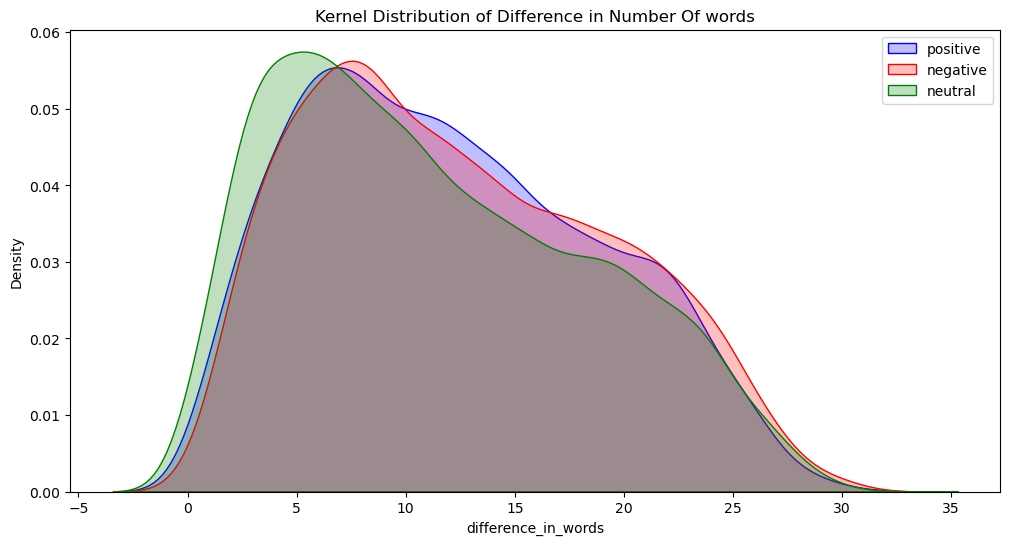

In [40]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")
p3 = sns.kdeplot(
    train[train["sentiment"] == "neutral"]["difference_in_words"], shade=True, color="g"
)
plt.legend(labels=["positive", "negative", "neutral"])

We can see that there is similarity between text and selected text .Let's have closer look

In [51]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Sentiment,Num_word_text,difference_in_words,text_length
100,3ff9947935,**** right!,**** right!,positive,0.0,1,2,1,13
151,d2f915b8c7,Good Morning!,Good,positive,0.0,1,2,1,15
154,b4fa2d20e4,Good one,Good one,positive,0.0,1,2,1,10
155,5714d8c2c3,Goodnight.,Goodnight,positive,0.0,1,1,0,12
334,6d9bd35d32,Thank you,Thank,positive,0.0,1,2,1,11
...,...,...,...,...,...,...,...,...,...
26454,0ccac3f8b7,sweet situations.,sweet situations.,positive,0.0,1,2,1,17
26484,6475ddf649,thanks,thanks,positive,0.0,1,1,0,7
26499,274181e2e2,thanx,thanx,positive,0.0,1,1,0,6
26933,28fc81d56a,wants cookie,wants cookie,positive,0.0,1,2,1,12


Thus its clear that most of the times , text is used as selected text.We can improve this by preprocessing the text which have word length less than 3.We will remember this information and use it in model building

### Cleaning the Corpus
Now Before We Dive into extracting information out of words in text and selected text,let's first clean the data

In [28]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [29]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [30]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


## Most Common words in our Target-Selected Text

In [31]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [32]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

OOPS!While we cleaned our dataset we didnt remove the stop words and hence we can see the most coomon word is 'to' . Let's try again after removing the stopwords

In [33]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [34]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [35]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

# Most Common words in Text

Let's also look at the most common words in Text

In [37]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [38]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


So the first two common word was I'm so I removed it and took data from second row

In [39]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

SO we can see the Most common words in Selected text and Text are almost the same,which was obvious

# Most common words Sentiments Wise

Let's look at the most common words in different sentiments

In [40]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [41]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [42]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [43]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [44]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [45]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [46]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [47]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

* We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis
* It will be interesting to see the word unique to different sentiments

## Let's Look at Unique Words in each Segment

We will look at unique words in each segment in the Following Order:
* Positive
* Negative
* Neutral

In [48]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [49]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Positive Tweets

In [50]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [51]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

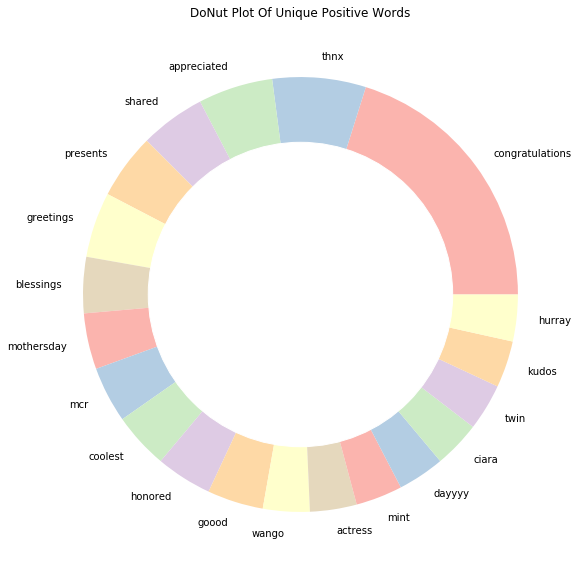

In [52]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [53]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


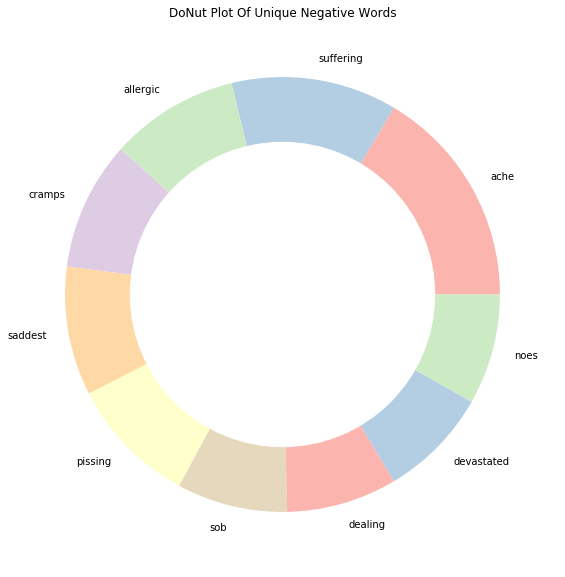

In [54]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [55]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


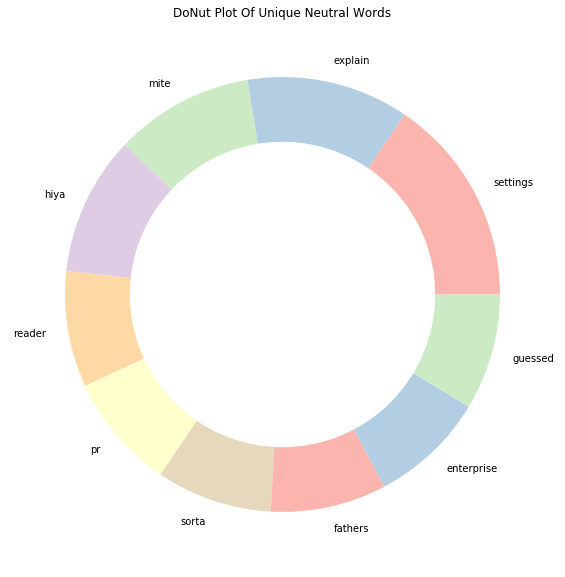

In [56]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

**By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets**

## It's Time For WordClouds

We will be building wordclouds in the following order:

* WordCloud of Neutral Tweets
* WordCloud of Positive Tweets
* WordCloud of Negative Tweets


In [59]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '/kaggle/input/masks-for-wordclouds/'

I have added more words like im , u (that we say were there in the most common words,disturbing our analysis) as stopwords

#### WORDCLOUD OF NEUTRAL TWEETS

We Have already visualized our Most Common Negative words ,but Wordclouds Provide us much more clarity

In [60]:
pos_mask = np.array(Image.open(d+ 'twitter_mask.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/masks-for-wordclouds/twitter_mask.png'

In [61]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

NameError: name 'pos_mask' is not defined

In [ ]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)

# Modelling

This is the first kaggle competition , I am participating in and this might be the case with lot of us.Due to the unique structure of the problem statement, it is hard for any first timer or a competitions noob to answer the question"Which Model to Use"?.My initial thoughts was this competition is not for me and I am done here,but then I remembered something, I was at the KaggleDays Meetup Delhi this year and I had this wonderful oppurtunity to meet Grandmaster Abhishek Thakur and during the Q&A session I asked him that kaggle competitions are so diverse ,unique ,require a lot of background knowledge and thus is scary to participate, to which he replied and I quote "Scary Yes!But so is walking into a dark room,you will never learn if you won't participate".

So here I am fighting my way through this competition and trying to learn different things and I urge everyone to do the same , I might not be so well established to give advices but I really wanted to share that story to motivate people.

After going through the discussion forums,taking advices from experts and watching Abhishek Sir's tutorial last night ,this problem can be modelled as following:-
* Named Entity Recognition
* Q&A Problem
* I also found a simple approach shared by Nick in his beautiful kernel where he has the concept of Gini Impurity to give weights to words present in tweets and then predicting using the weight of those words : https://www.kaggle.com/nkoprowicz/a-simple-solution-using-only-word-counts/notebook .Do check it out.
* Other Modelling Ideas :- https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/139803 --> Here is a very Nice Idea
* Another useful Idea :- https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/139335

Resources :
* For Modelling Problem as NER : https://www.kaggle.com/rohitsingh9990/ner-training-using-spacy-0-628-lb
* For Modelling Problem AS Q&A : https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack ---> This is a complete Guide and From scratch

## 1)Modelling the Problem as NER

Named Entity Recognition (NER) is a standard NLP problem which involves spotting named entities (people, places, organizations etc.) from a chunk of text, and classifying them into a predefined set of categories.
For understanding NER here is very good article : https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

We will be using spacy for creating our own customised NER model or models (seperate for each Sentiment).The motivation for this approach is off course the kernel shared by Rohit Singh,so if you find his kernel useful please upvote it.

What will be different with my solution:
* I will use text as selected_text for all neutral tweets due to their high jaccard similarity
* Also I will use text as selected_text for all tweets having number of words less than 3 in text as explained before
* I will train two different models for Positive and Negtive tweets
* I will not preprocess the data because the selected text contains raw text

In [62]:
df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
df_submission = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [63]:
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set

In [64]:
df_train = df_train[df_train['Num_words_text']>=3]

In [72]:
df_train.head()

,textID,text,selected_text,sentiment,Num_words_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14


**For Full Understanding of the how to train spacy NER with custom inputs, please read the spacy documentation along with the code presentation in this notebook : https://spacy.io/usage/training#ner Follow along from Updating Spacy NER**

In [65]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [66]:
# pass model = nlp if you want to train on top of existing model 

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [73]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    elif sentiment == 'neutral':
        model_out_path = 'models/model_net'
    return model_out_path

In [74]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

#### Training models for Positive and Negative tweets

In [69]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# For DEmo Purposes I have taken 3 iterations you can train the model as you want
train(train_data, model_path, n_iter=3, model=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|███▎      | 1/3 [00:46<01:33, 46.96s/it]

Losses {'ner': 34062.65376441149}


 67%|██████▋   | 2/3 [01:33<00:46, 46.78s/it]

Losses {'ner': 31145.054226267228}


100%|██████████| 3/3 [02:19<00:00, 46.47s/it]

Losses {'ner': 28857.55965697156}
Saved model to ../working/models/model_pos


In [70]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|███▎      | 1/3 [00:44<01:28, 44.13s/it]

Losses {'ner': 32248.869369077176}


 67%|██████▋   | 2/3 [01:27<00:43, 43.99s/it]

Losses {'ner': 28541.33342894423}


100%|██████████| 3/3 [02:11<00:00, 43.82s/it]

Losses {'ner': 27221.88862677048}
Saved model to ../working/models/model_neg


In [75]:
sentiment = 'neutral'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|███▎      | 1/3 [00:54<01:49, 54.60s/it]

Losses {'ner': 6893.681141112336}


 67%|██████▋   | 2/3 [01:52<00:55, 55.72s/it]

Losses {'ner': 5089.8404631342355}


100%|██████████| 3/3 [02:54<00:00, 58.09s/it]

Losses {'ner': 5208.912640908143}
Saved model to ../working/models/model_net


### Predicting with the trained Model

In [76]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [82]:
selected_texts = []
MODELS_BASE_PATH = '/kaggle/working/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_net')

        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  /kaggle/working/models/


In [83]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Good
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!
5,726e501993,that`s great!! weee!! visitors!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and mys..."
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...
